In [9]:
import yfinance as yf

# Download data
tickers = ['AAPL', 'GOOGL', 'MSFT']
df = yf.download(tickers, start="2020-01-01", end="2024-12-31", group_by='ticker', auto_adjust=True)

# Fix MultiIndex names (if needed)
df.columns.names = ['Price', 'Ticker']

[*********************100%***********************]  3 of 3 completed


In [10]:
df.columns


MultiIndex([( 'MSFT',   'Open'),
            ( 'MSFT',   'High'),
            ( 'MSFT',    'Low'),
            ( 'MSFT',  'Close'),
            ( 'MSFT', 'Volume'),
            ('GOOGL',   'Open'),
            ('GOOGL',   'High'),
            ('GOOGL',    'Low'),
            ('GOOGL',  'Close'),
            ('GOOGL', 'Volume'),
            ( 'AAPL',   'Open'),
            ( 'AAPL',   'High'),
            ( 'AAPL',    'Low'),
            ( 'AAPL',  'Close'),
            ( 'AAPL', 'Volume')],
           names=['Price', 'Ticker'])

In [12]:
import pandas as pd
import numpy as np

# Function to calculate RSI
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Function to add financial indicators
def add_indicators(df_ticker):
    # Simple Moving Average
    df_ticker['SMA_20'] = df_ticker['Close'].rolling(window=20).mean()
    # Exponential Moving Average
    df_ticker['EMA_20'] = df_ticker['Close'].ewm(span=20, adjust=False).mean()
    # RSI
    df_ticker['RSI_14'] = compute_rsi(df_ticker['Close'], window=14)
    # Bollinger Bands
    sma = df_ticker['Close'].rolling(window=20).mean()
    std = df_ticker['Close'].rolling(window=20).std()
    df_ticker['Bollinger_Upper'] = sma + (std * 2)
    df_ticker['Bollinger_Lower'] = sma - (std * 2)
    return df_ticker

# Assuming df is your DataFrame with MultiIndex columns (tickers at level 0)
tickers = df.columns.levels[0]  # e.g. ['GOOGL', 'MSFT', 'AAPL']
processed = []

for ticker in tickers:
    # Extract ticker data, columns become ['Open', 'High', 'Low', 'Close', 'Volume']
    df_ticker = df.xs(ticker, level=0, axis=1).copy()

    # Add indicators
    df_ticker = add_indicators(df_ticker)

    # Add ticker column for tracking after concat
    df_ticker['Ticker'] = ticker

    processed.append(df_ticker)

# Combine all processed ticker data back together, reset index if needed
df_processed = pd.concat(processed)
df_processed.reset_index(inplace=True)  # If Date is index, moves to column

print(df_processed.head())


Ticker       Date       Open       High        Low      Close     Volume  \
0      2020-01-02  71.627077  72.681274  71.373203  72.620827  135480400   
1      2020-01-03  71.847110  72.676439  71.689950  71.914810  146322800   
2      2020-01-06  71.034724  72.526549  70.783263  72.487862  118387200   
3      2020-01-07  72.497522  72.753816  71.926907  72.146935  108872000   
4      2020-01-08  71.849540  73.609752  71.849540  73.307518  132079200   

Ticker  SMA_20     EMA_20  RSI_14  Bollinger_Upper  Bollinger_Lower Ticker  
0          NaN  72.620827     NaN              NaN              NaN   AAPL  
1          NaN  72.553587     NaN              NaN              NaN   AAPL  
2          NaN  72.547327     NaN              NaN              NaN   AAPL  
3          NaN  72.509195     NaN              NaN              NaN   AAPL  
4          NaN  72.585226     NaN              NaN              NaN   AAPL  


**DBSCAN Anomaly Detection on Enriched Data**

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
import numpy as np

# Select features for clustering/anomaly detection
features = ['SMA_20', 'EMA_20', 'RSI_14', 'Bollinger_Upper', 'Bollinger_Lower']

# Drop rows with NaNs in features (because rolling calculations cause NaNs)
df_clean = df_processed.dropna(subset=features).copy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_clean[features])

# Fit DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)  # You can tune eps and min_samples
dbscan.fit(X_scaled)

# Add DBSCAN labels to the DataFrame
df_clean['dbscan_label'] = dbscan.labels_

# -1 label means outlier/anomaly
print("Number of anomalies detected:", sum(dbscan.labels_ == -1))

# Example: filter anomalies
anomalies = df_clean[df_clean['dbscan_label'] == -1]
print(anomalies.head())


Number of anomalies detected: 4
Ticker       Date        Open        High         Low       Close     Volume  \
289    2021-02-25  121.807322  123.546309  117.762710  118.202339  148199500   
290    2021-02-26  119.765468  121.973399  118.407495  118.466118  164560400   
3489   2023-11-15  367.112789  368.942031  362.989579  365.520874   26860100   
3490   2023-11-16  366.796392  372.125909  366.025147  371.947937   27182300   

Ticker      SMA_20      EMA_20     RSI_14  Bollinger_Upper  Bollinger_Lower  \
289     129.236217  127.510625   3.179965       138.323158       120.149277   
290     128.472946  126.649243   4.783983       138.487195       118.458697   
3489    343.239742  347.432814  89.725406       374.783319       311.696164   
3490    345.490250  349.767588  90.537357       378.524037       312.456462   

Ticker Ticker  dbscan_label  
289      AAPL            -1  
290      AAPL            -1  
3489     MSFT            -1  
3490     MSFT            -1  


**Prophet Forecasting Code**

In [15]:
print(df.columns.names)  # Should print ['Price', 'Ticker']
print(df.columns.levels) # Check order of levels
print(df.columns)        # Check actual tuples to confirm level order


['Price', 'Ticker']
[['AAPL', 'GOOGL', 'MSFT'], ['Close', 'High', 'Low', 'Open', 'Volume']]
MultiIndex([( 'MSFT',   'Open'),
            ( 'MSFT',   'High'),
            ( 'MSFT',    'Low'),
            ( 'MSFT',  'Close'),
            ( 'MSFT', 'Volume'),
            ('GOOGL',   'Open'),
            ('GOOGL',   'High'),
            ('GOOGL',    'Low'),
            ('GOOGL',  'Close'),
            ('GOOGL', 'Volume'),
            ( 'AAPL',   'Open'),
            ( 'AAPL',   'High'),
            ( 'AAPL',    'Low'),
            ( 'AAPL',  'Close'),
            ( 'AAPL', 'Volume')],
           names=['Price', 'Ticker'])


In [19]:
# Swap levels first to get tickers at level 0
df.columns = df.columns.swaplevel(0, 1)

# Fix level names accordingly
df.columns.names = ['Ticker', 'Price']

# Check it now
print(df.columns)
print(df.columns.names)


MultiIndex([( 'MSFT',   'Open'),
            ( 'MSFT',   'High'),
            ( 'MSFT',    'Low'),
            ( 'MSFT',  'Close'),
            ( 'MSFT', 'Volume'),
            ('GOOGL',   'Open'),
            ('GOOGL',   'High'),
            ('GOOGL',    'Low'),
            ('GOOGL',  'Close'),
            ('GOOGL', 'Volume'),
            ( 'AAPL',   'Open'),
            ( 'AAPL',   'High'),
            ( 'AAPL',    'Low'),
            ( 'AAPL',  'Close'),
            ( 'AAPL', 'Volume')],
           names=['Ticker', 'Price'])
['Ticker', 'Price']


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo0o_t57f/9bvvbsvh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpo0o_t57f/lsrivanl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=40503', 'data', 'file=/tmp/tmpo0o_t57f/9bvvbsvh.json', 'init=/tmp/tmpo0o_t57f/lsrivanl.json', 'output', 'file=/tmp/tmpo0o_t57f/prophet_modellgzh2lrj/prophet_model-20250518093052.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:30:52 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
09:30:52 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


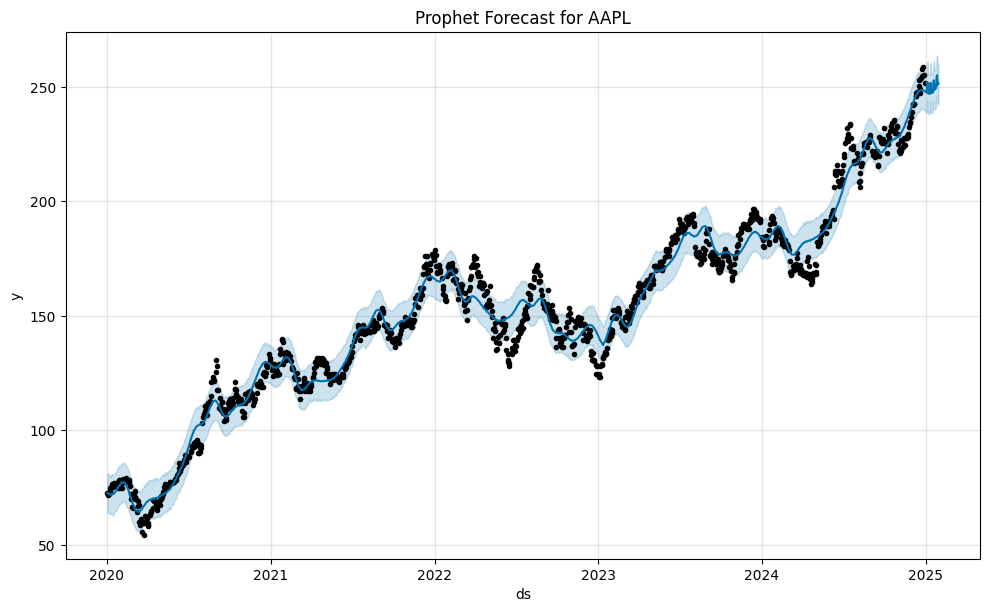

In [20]:
from prophet import Prophet
import matplotlib.pyplot as plt

def prophet_forecast(df, ticker, periods=30):
    # Prepare data
    df_ticker = df.xs(ticker, level='Ticker', axis=1).reset_index()
    df_ticker = df_ticker[['Date', 'Close']].rename(columns={'Date':'ds', 'Close':'y'})

    # Prophet model
    model = Prophet()
    model.fit(df_ticker)

    # Create future dataframe
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)

    # Plot forecast
    fig = model.plot(forecast)
    plt.title(f"Prophet Forecast for {ticker}")
    plt.show()

    return forecast

# Example usage:
forecast_aapl = prophet_forecast(df, 'AAPL')


**Visualizing Anomalies on Stock Price Trends**

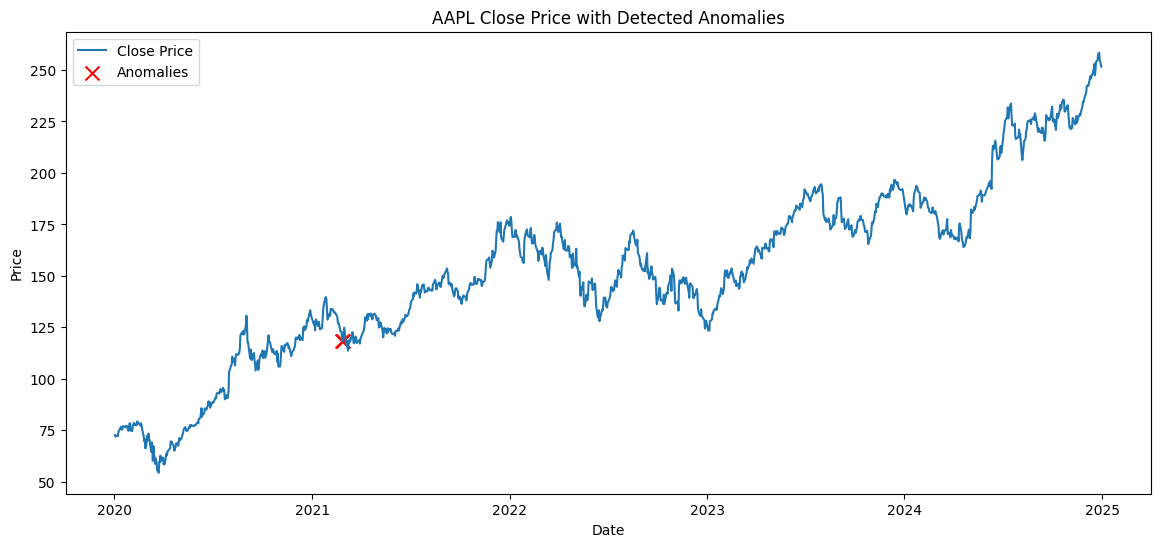

In [22]:
import matplotlib.pyplot as plt

def plot_anomalies(df, df_clean, ticker):
    # Extract ticker data (all price columns for that ticker)
    df_ticker = df.xs(ticker, level='Ticker', axis=1).reset_index()

    # Extract anomalies for that ticker from df_clean
    # Assuming df_clean has a MultiIndex on columns or index with 'Ticker' level
    if 'Ticker' in df_clean.index.names:
        df_clean_ticker = df_clean.xs(ticker, level='Ticker')
    else:
        # If 'Ticker' is a normal column, filter like this:
        df_clean_ticker = df_clean[df_clean['Ticker'] == ticker]

    plt.figure(figsize=(14, 6))
    plt.plot(df_ticker['Date'], df_ticker['Close'], label='Close Price')

    # Plot anomalies (dbscan_label == -1) if column exists
    if 'dbscan_label' in df_clean_ticker.columns:
        anomalies = df_clean_ticker[df_clean_ticker['dbscan_label'] == -1]
        plt.scatter(anomalies['Date'], anomalies['Close'], color='red', label='Anomalies', marker='x', s=100)
    else:
        print("Warning: 'dbscan_label' column not found in df_clean_ticker")

    plt.title(f"{ticker} Close Price with Detected Anomalies")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.show()

# Example usage:
plot_anomalies(df, df_clean, 'AAPL')
